In [1]:
import tensorflow as tf
import numpy as np
import Censai as Celi
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
sess = tf.InteractiveSession()

In [3]:
Raytracer = Celi.Likelihood(numpix_side = 192)

In [4]:
Datagen = Celi.DataGenerator(numpix_side=Raytracer.numpix_side, numkappa_side=193, src_side=Raytracer.src_side, im_side = Raytracer.im_side,max_noise_rms=0.0,use_psf=False,lens_model_error=[0.01,0.01,0.01,0.01,0.01,0.01,0.01],binpix=1,mask=False,min_unmasked_flux=1.0)

In [5]:
batch_size = 2

Datagen.X = np.zeros((batch_size, Datagen.numpix_side , Datagen.numpix_side,1 ))
Datagen.source = np.zeros((batch_size, Datagen.numpix_side , Datagen.numpix_side,1 ))
Datagen.kappa = np.zeros((batch_size, Datagen.numkappa_side , Datagen.numkappa_side,1 ))
max_file_num=None
train_or_test = 'train'
read_or_gen = 'gen'

In [6]:
Datagen.read_data_batch(Datagen.X ,Datagen.source , train_or_test, read_or_gen)

Censai/get_data.py:73: RuntimeWarning: divide by zero encountered in divide
  kappa = np.divide( np.sqrt(1-elp)* Rein ,  (2* np.sqrt( r**2 + rc**2)))


In [7]:
Kappatest = tf.placeholder( tf.float32, [None, Datagen.numkappa_side, Datagen.numkappa_side,1] )
Srctest = tf.placeholder( tf.float32, [None, Raytracer.numpix_side, Raytracer.numpix_side,1] )


IM = Raytracer.get_lensed_image(Kappatest,[0.,0.], 7.68, Srctest)


imout= sess.run(IM, feed_dict={Srctest: Datagen.source, Kappatest: Datagen.kappa})

In [8]:
print imout.shape

(2, 192, 192, 1)


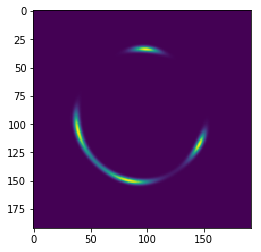

In [10]:
plt.imshow(imout[1,:,:,0])